In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib as mpl

import raddetect as rd

In [2]:
from scipy.stats import crystalball
from scipy.stats import norm

In [3]:
# It works only in the MPIK network
blumchen = rd.BlumchenAnalysis(url='https://radon-srv1.mpi-hd.mpg.de/coating_db/resultfiles', filename='Rn08052024')

Retriving data from https://radon-srv1.mpi-hd.mpg.de/coating_db/resultfiles/Rn08052024//rn08052024.root


Selection:
	-MCA range: [0, 1300]
	-time range: [0, inf] minutes
Selection:
	-MCA range: [910, 1060]
	-time range: [0, inf] minutes


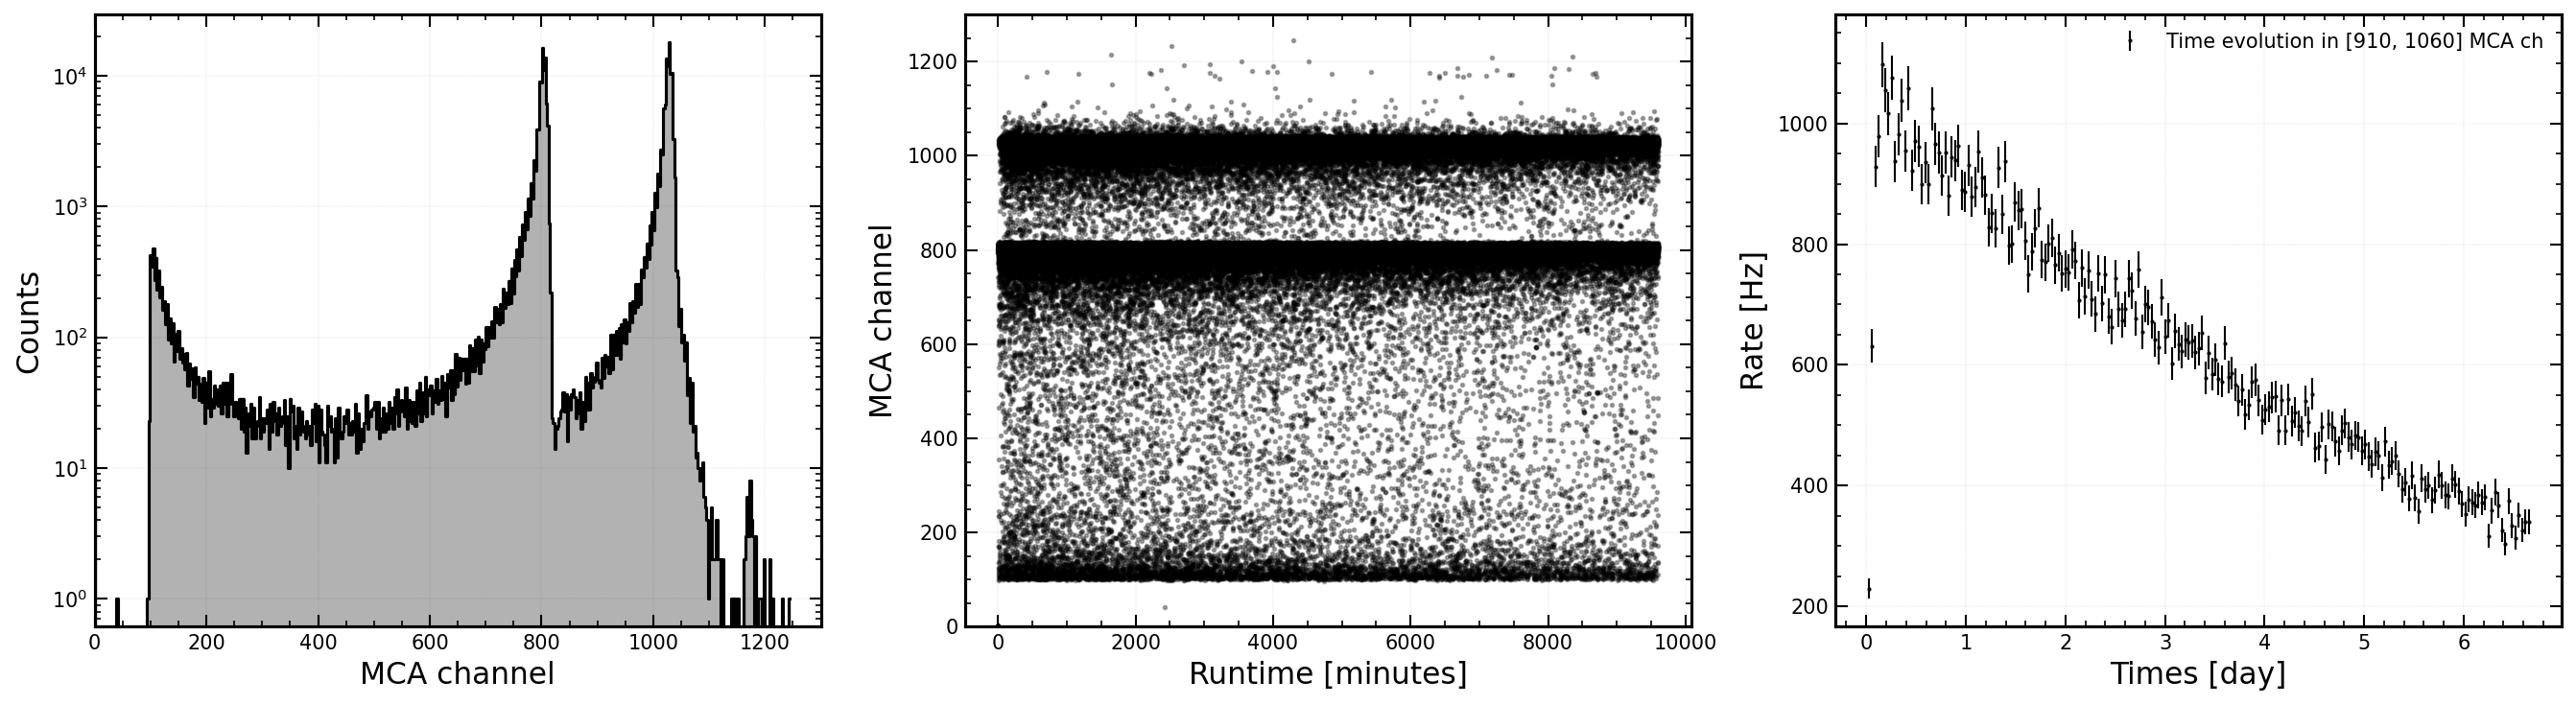

In [4]:
blumchen.get_base_plot(n_channels=500, n_timestamp=200)

## Fir spectrum

In [5]:
def Model(
    x, 
    beta1, m1, loc1, scale1, 
    # A1_1, 
    A1_2,
    beta2, m2, loc2, scale2, 
    # A2_1, 
    A2_2,
    # a, b
    ):
    # _gauss_1 = A1_1 * sp.stats.norm.pdf(x, loc=loc1, scale=scale1)
    _crystalball_1 = A1_2 * sp.stats.crystalball.pdf(x, beta1, m1, loc=loc1, scale=scale1)
    
    # _gauss_2 = A2_1 * sp.stats.norm.pdf(x, loc=loc1, scale=scale1)
    _crystalball_2 = A2_2 * sp.stats.crystalball.pdf(x, beta2, m2, loc=loc2, scale=scale2)
    
    # _linear = a * x + b
    
    return _crystalball_1 + _crystalball_2

init = {
    'beta1': 0.987, 'm1': 1.894, 'loc1': 804.432, 'scale1': 4.774, 
    # 'A1_1': 94.8e3 / 2, 
    'A1_2': 94.8e3 / 2,
    'beta2': 1.097, 'm2': 1.89, 'loc2': 1029.57, 'scale2': 5.057, 
    # 'A2_1': 101.2e3 / 2, 
    'A2_2': 101.2e3 / 2,
    # 'a': 0, # -0.0135, 
    # 'b': 0, # 9
}

fixed = {
    'beta1': False, 'm1': False, 'loc1': False, 'scale1': False, 
    # 'A1_1': False, 
    'A1_2': False,
    'beta2': False, 'm2': False, 'loc2': False, 'scale2': False, 
    # 'A2_1': False, 
    'A2_2': False,
    # 'a': True, 'b': True
    
}

_MCA_range = [600, 1039]
_MCA_counts_limit = 10
m = blumchen.get_mca_spectrum_fitting_object(model=Model, init=init, MCA_range=_MCA_range, MCA_counts_limit=_MCA_counts_limit, fixed=fixed)
m.migrad()
m.minos()
m.hesse()

Selection:
	-MCA range: [600, 1039]
	-time range: [240, inf] minutes


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1110 (χ²/ndof = 2.8)       │             Nfcn = 1636              │
│ EDM = 2.45e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ beta1  │   0.998   │   0.010   │   -0.010   │   0.010    │         │         │       │
│ 1 │ m1     │   1.873   │   0.021   │   -0.021   │   0.021    │         │         │       │
│ 2 │ loc1   │  804.320  │   0.033   │   -0.033   │   0.033    │         │         │       │
│ 3 │ scale1 │   4.793   │   0.021   │   -0.021   │   0.021    │         │         │       │
│ 4 │ A1_2   │  94.88e3  │  0.34e3   │  -0.34e3   │   0.34e3   │         │         │       │
│ 5 │ beta2  │   1.166   │   0.011   │   -0.011   │   0.011    │         │         │       │
│ 6 │ m2     │   1.886   │   0.022   │   -0.022   │   0.022    │         │         │       │
│ 7 │ loc2   │1.029667e3 │0.000028e3 │-0.000028e3 │ 0.000028e3 │         │         │       │
│ 8 │ scale2 │   5.498   │   0.035   │   -0.035   │   0.035    │         │         │       │
│ 9 │ A2_2   │  102.8e3  │   0.4e3   │   -0.4e3   │   0.4e3    │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         beta1         │          m1           │         loc1          │        scale1         │         A1_2          │         beta2         │          m2           │         loc2          │        scale2         │         A2_2          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.01   │   0.01    │  -0.021   │   0.021   │  -0.033   │   0.033   │  -0.021   │   0.021   │  -0.34e3  │  0.34e3   │  -0.011   │   0.011   │  -0.022   │   0.022   │  -0.028   │   0.028   │  -0.035   │   0.035   │  -0.4e3   │   0.4e3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   

Selection:
	-MCA range: [0, 1300]
	-time range: [240, inf] minutes
Selection:
	-MCA range: [600, 1039]
	-time range: [240, inf] minutes


/tmp/ipykernel_28947/436491466.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


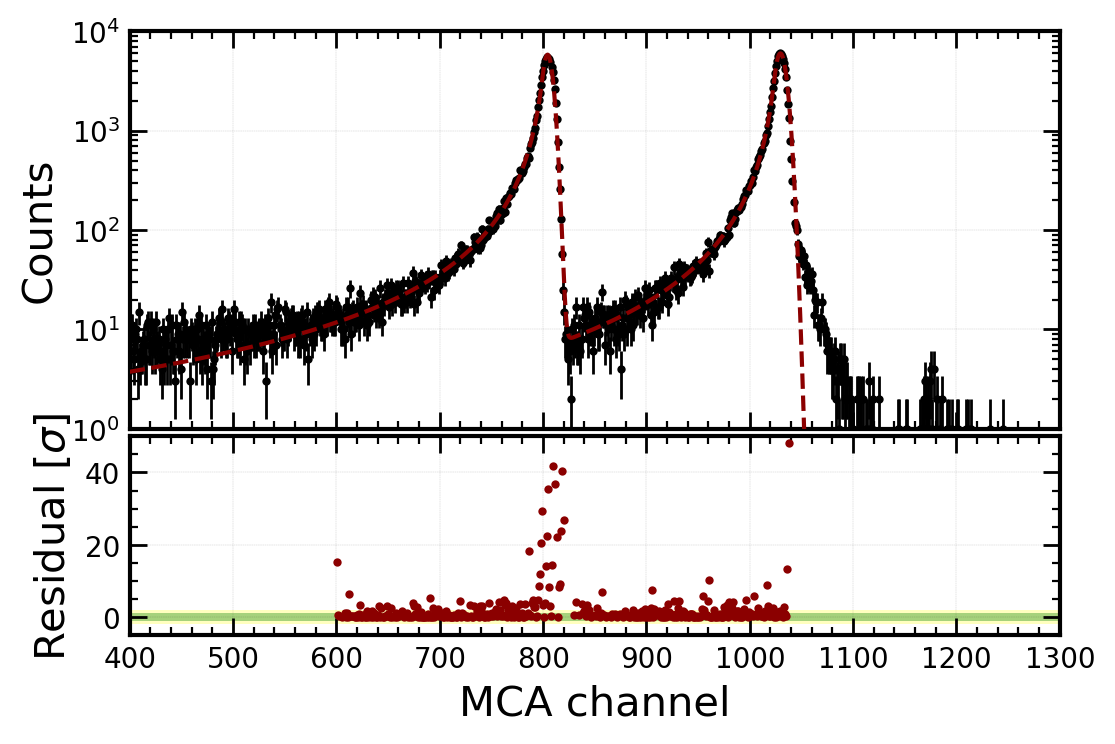

In [6]:
data, channels = blumchen.get_mca_histogram(MCA_range=[0, 1300])
_data, _channels = blumchen.get_mca_histogram(MCA_range=_MCA_range)
mask = (_data > _MCA_counts_limit)
_data = _data[mask]
_channels = _channels[mask]

x = np.arange(0, 1300, 0.1)

fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200, sharex=True, gridspec_kw={'height_ratios':[2,1], 'hspace': 0.025})

ax1.errorbar(channels, data, yerr=np.sqrt(data), lw=0, marker='o', color='black', ms=3, elinewidth=1)

l = ax1.plot(x, Model(x, *np.array(m.values)), ls='--', color='darkred', zorder=5)

ax2.plot(_channels, ( (_data - Model(_channels, *np.array(m.values))) / np.sqrt(_data) )** 2, lw=0, marker='.', color=l[0].get_color())

ax2.axhspan(-2, 2, color='yellow', lw=0, alpha=0.25)
ax2.axhspan(-1, 1, color='green', lw=0, alpha=0.35)

ax1.set_yscale('log')
ax1.set_ylim(1e0, 1e4)
ax1.set_xlim(400, 1300)

ax1.grid()

ax2.set_ylim(-5, 50)
ax2.grid()

ax2.set_xlabel('MCA channel')
ax1.set_ylabel('Counts')
ax2.set_ylabel('Residual [$\sigma$]')
        
plt.tight_layout()
plt.show()

## Fit time evolution

In [7]:
def Model(
    x, 
    A, tau, t0
    ):
    return A * np.exp(- (x - t0) /tau )

init = {
    'A': 1e4, 'tau': 3.8 * 24 * 60 * 60 / np.log(2), 't0': 4 * 60 * 60,
}
fixed = {
    't0': True
}

_n_timestamp = 300
m = blumchen.get_time_evolution_fitting_object(model=Model, init=init, fixed=fixed, n_timestamp=_n_timestamp)
m.migrad()
m.minos()
m.hesse()

Selection:
	-MCA range: [910, 1060]
	-time range: [240, inf] minutes


/tmp/ipykernel_28947/3260256941.py:5: RuntimeWarning: overflow encountered in exp
  return A * np.exp(- (x - t0) /tau )
/tmp/ipykernel_28947/3260256941.py:5: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(- (x - t0) /tau )
/home/volta/.local/lib/python3.10/site-packages/iminuit/cost.py:128: RuntimeWarning: overflow encountered in multiply
  return z * z


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 337.3 (χ²/ndof = 1.1)      │              Nfcn = 230              │
│ EDM = 8.99e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  1.050e3  │  0.006e3  │  -0.006e3  │  0.006e3   │         │         │       │
│ 1 │ tau  │   494e3   │    5e3    │    -5e3    │    5e3     │         │         │       │
│ 2 │ t0   │  14.40e3  │  0.14e3   │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           A           │          tau          │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -6     │     6     │   -5e3    │    5e3    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌─────┬───────────────────────────────┐
│     │         A       tau        t0 │
├─────┼───────────────────────────────┤
│   A │      34.7 -23.801e3         0 │
│ tau │ -23.801e3  2.42e+07         0 │
│  t0 │         0         0         0 │
└─────┴───────────────────────────────┘

Selection:
	-MCA range: [910, 1060]
	-time range: [240, inf] minutes


/tmp/ipykernel_28947/2046165332.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


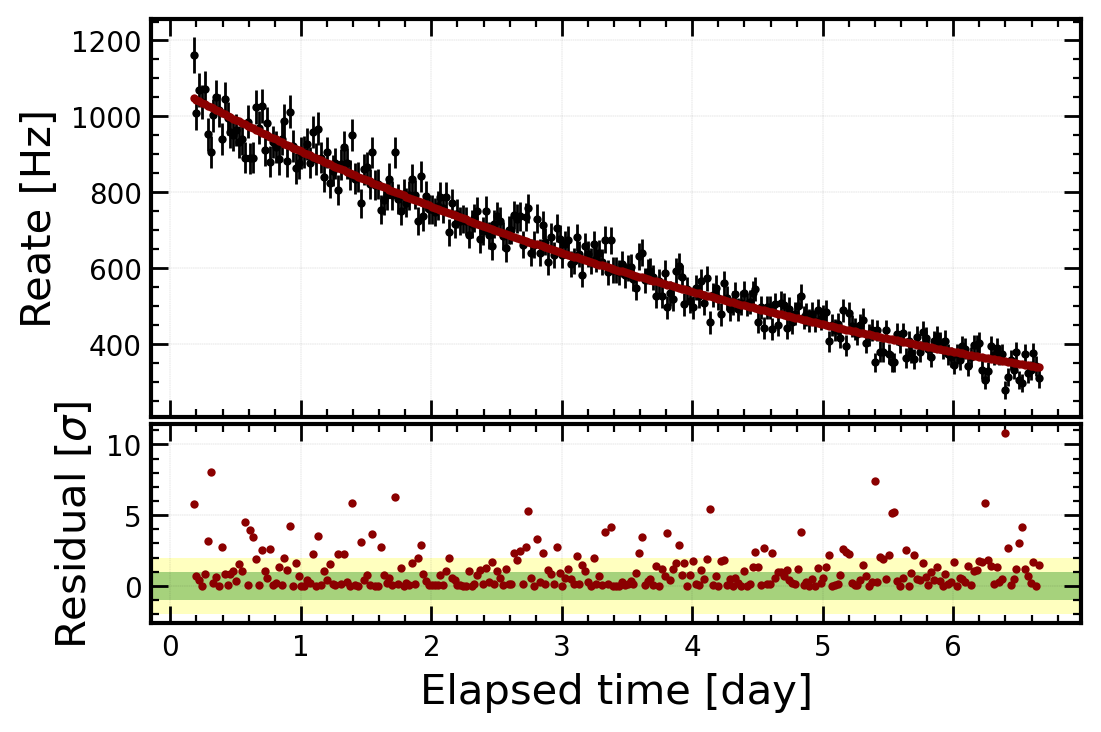

In [8]:
times, rate, rate_err = blumchen.get_time_evolution(n_timestamp=_n_timestamp)

x = np.arange(0, 7, 0.1)

fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200, sharex=True, gridspec_kw={'height_ratios':[2,1], 'hspace': 0.025})

ax1.errorbar(times / 60 / 60 / 24, rate, yerr=rate_err, lw=0, marker='o', color='black', ms=3, elinewidth=1)

# l = ax1.plot(x, Model(x * 60 * 60 * 24, *np.array(m.values)), ls='--', color='darkred', zorder=5)
l = ax1.plot(times / 60 / 60 / 24, Model(times, *np.array(m.values)), marker='o', ls='--', ms=3, color='darkred', zorder=5)

ax2.plot(times / 60 / 60 / 24, ( (rate - Model(times, *np.array(m.values))) / rate_err )** 2, lw=0, marker='.', color=l[0].get_color())

ax2.axhspan(-2, 2, color='yellow', lw=0, alpha=0.25)
ax2.axhspan(-1, 1, color='green', lw=0, alpha=0.35)

ax1.grid()
ax2.grid()

ax2.set_xlabel('Elapsed time [day]')
ax1.set_ylabel('Reate [Hz]')
ax2.set_ylabel('Residual [$\sigma$]')

plt.tight_layout()
plt.show()